# Transparancy Analysis Using SHAP

In [1]:
# Required installations
!pip install numba==0.48
!pip install aif360==0.3.0rc0
!pip install BlackBoxAuditing
!pip install shap==0.39.0

In [2]:
# Import the required modules
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.postprocessing import EqOddsPostprocessing, RejectOptionClassification
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from aif360.datasets import BinaryLabelDataset



from google.colab import files
import io

import shap
from IPython.display import Image
from IPython.core.display import HTML 
import operator
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
shap.initjs()

Matplotlib Error, comment out matplotlib.use('TkAgg')


##Model Contruction

#### Loading and Splitting Data

In [3]:
#read in the dataset
uploaded = files.upload()
heart = pd.read_csv(io.BytesIO(uploaded['heart.csv']))

heart.head()

Saving heart.csv to heart.csv


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
#split data into X and y and scale the X as done in the ADS
X = heart[list(heart.columns)[0:-1]]
y = heart['target']

X_norm = normalize(X, norm='l2')

In [5]:
#split the dataset into train, val, test using the same seeds as the ADS
X_train, X_hold, y_train, y_hold = train_test_split(X_norm, y, test_size=0.33, random_state=101) 
X_val, X_test, y_val, y_test = train_test_split(X_hold, y_hold, test_size=0.5, random_state=42)

y_train = np.array(y_train)
y_hold = np.array(y_hold)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [6]:
#Splitting out additional dataframes with the unscaled data
X_check_train, X_thing = train_test_split(X, test_size=0.33, random_state=101) 
X_check_val, X_check_test = train_test_split(X_thing, test_size=0.5, random_state=42)

#### Fitting Model
Use the same parameters and seed as the ADS

In [7]:
#run this model matching ADS params
model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1)
model.fit(X_train, y_train)

#confirm same prediction scores as ADS
print('Small Test Set')
print('Val score:',model.score(X_val, y_val))
print('Test score:',model.score(X_test, y_test))

print('Large Hold-out Set')
print('Test score:',model.score(X_hold, y_hold))

#save preditions on test data
preds_test = model.predict(X_test)
preds_hold = model.predict(X_hold)

Small Test Set
Val score: 0.78
Test score: 0.92
Large Hold-out Set
Test score: 0.85


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


## Explain the Model using Feature Importances

Unfourtunately because the ADS systems were are investigating uses sci-kit-learn's MLP classifier, there is no feature importance method to determine the global weight of each feature.  Hence, we use the SHAP explainer below and develop our own metrics.

## Explain the model using SHAP

###Build and Analyze SHAP explainer

In [8]:
# Initialize the explainer -- had to sample down data to 75 due to model complexity
explainer = shap.KernelExplainer(model.predict_proba, shap.sample(X_train, nsamples=75, random_state=10))
# Apply it to the test data
shap_values = explainer.shap_values(X_hold)

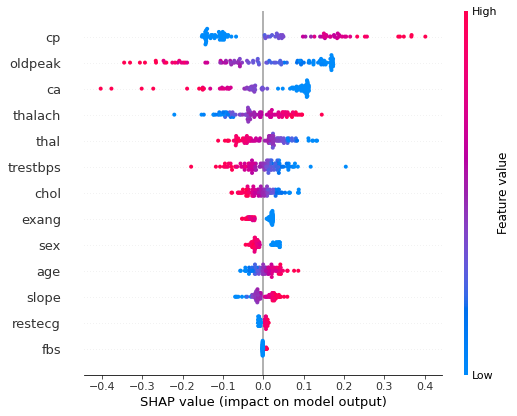

In [9]:
#Plot out shap summary for target==1 (positive diagnosis)
shap.initjs()
shap.summary_plot(shap_values[1], X_hold, feature_names=heart.columns[:-1])

####Notes
 A superficial analysis of the SHAP plot gives a fair amount of confidence in the model.  Feature values are correlated positively or negatively in a consistent manner with SHAP values for most instances.

### SHAP Values for Individual Cases
Below we show the full decomposition of SHAP contributions for selected instances.  We note how the case was classified and the gender.  It’s immediately noticeable that features commonly making the largest contributions in these examples are ‘oldpeak,' 'ca,' and 'cp.'  Though not necessarily in the same direction each time.

In [10]:
# Compute the accuracy of the classifier and the number of misclassified documents
print("misclassification count: {}".format(np.sum(preds_hold != y_hold)))
print('confusion matrix:')
confusion_matrix(y_hold, preds_hold)

misclassification count: 15
confusion matrix:


array([[38, 10],
       [ 5, 47]])

In [11]:
##create arrays of idices for TN, TP, and correct classification
FP_idx = np.argwhere((preds_hold - y_hold) == 1)[:,0]
FN_idx = np.argwhere((preds_hold - y_hold) == -1)[:,0]
TPTN_idx = np.argwhere((preds_hold - y_hold) == 0)[:,0]

#seperate FP by sex 
FP_female_idx = FP_idx[(X_hold[FP_idx,1] == 0)]
FP_male_idx = FP_idx[(X_hold[FP_idx,1] != 0)]

#seperate FN by sex 
FN_female_idx = FN_idx[(X_hold[FN_idx,1] == 0)]
FN_male_idx = FN_idx[(X_hold[FN_idx,1] != 0)]

#seperate TP by sex 
TPTN_female_idx = TPTN_idx[(X_hold[TPTN_idx,1] == 0)]
TPTN_male_idx = TPTN_idx[(X_hold[TPTN_idx,1] != 0)]

#### False Positive Classifications

In [12]:
#False Positive Calssification for Female Example
shap.initjs()
idx = FP_female_idx[0]

print("True Positive" if y_hold[idx] else "True Negative")
print("Positive" if preds_hold[idx] else "Negative", "Diagnosis")
print("Sex: Female" if X_hold[idx,1] ==0 else "Sex: Male")
shap.force_plot(
    explainer.expected_value[1], shap_values[1][idx,:], X_hold[idx,:],
    feature_names=heart.columns[:-1])

True Negative
Positive Diagnosis
Sex: Female


In [13]:
#False Positive Calssification for Male Example
shap.initjs()
idx = FP_male_idx[0]

print("True Positive" if y_hold[idx] else "True Negative")
print("Positive" if preds_hold[idx] else "Negative", "Diagnosis")
print("Sex: Female" if X_hold[idx,1] ==0 else "Sex: Male")
shap.force_plot(
    explainer.expected_value[1], shap_values[1][idx,:], X_hold[idx,:],
    feature_names=heart.columns[:-1])

True Negative
Positive Diagnosis
Sex: Male


####False Negative Classification

In [14]:
#False Positive Calssification for Female Example
shap.initjs()
idx = FN_female_idx[0]

print("True Positive" if y_hold[idx] else "True Negative")
print("Positive" if preds_hold[idx] else "Negative", "Diagnosis")
print("Sex: Female" if X_hold[idx,1] ==0 else "Sex: Male")
shap.force_plot(
    explainer.expected_value[1], shap_values[1][idx,:], X_hold[idx,:],
    feature_names=heart.columns[:-1])

True Positive
Negative Diagnosis
Sex: Female


In [15]:
#False Positive Calssification for Female Example
shap.initjs()
idx = FN_male_idx[3]

print("True Positive" if y_hold[idx] else "True Negative")
print("Positive" if preds_hold[idx] else "Negative", "Diagnosis")
print("Sex: Female" if X_hold[idx,1] ==0 else "Sex: Male")
shap.force_plot(
    explainer.expected_value[1], shap_values[1][idx,:], X_hold[idx,:],
    feature_names=heart.columns[:-1])

True Positive
Negative Diagnosis
Sex: Male


####Correct Classifications - Female

In [16]:
#Correct Positive Classification for Female
shap.initjs()
idx = TPTN_female_idx[0]

print("True Positive" if y_hold[idx] else "True Negative")
print("Positive" if preds_hold[idx] else "Negative", "Diagnosis")
print("Sex: Female" if X_hold[idx,1] ==0 else "Sex: Male")
shap.force_plot(
    explainer.expected_value[1], shap_values[1][idx,:], X_hold[idx,:],
    feature_names=heart.columns[:-1])

True Positive
Positive Diagnosis
Sex: Female


In [17]:
#Correct Negative Classification for Female
shap.initjs()
idx = TPTN_female_idx[14]

print("True Positive" if y_hold[idx] else "True Negative")
print("Positive" if preds_hold[idx] else "Negative", "Diagnosis")
print("Sex: Female" if X_hold[idx,1] ==0 else "Sex: Male")
shap.force_plot(
    explainer.expected_value[1], shap_values[1][idx,:], X_hold[idx,:],
    feature_names=heart.columns[:-1])

True Negative
Negative Diagnosis
Sex: Female


####Correct Classifications - Male

In [18]:
#Correct Negative Classification for Female
shap.initjs()
idx = TPTN_male_idx[1]

print("True Positive" if y_hold[idx] else "True Negative")
print("Positive" if preds_hold[idx] else "Negative", "Diagnosis")
print("Sex: Female" if X_hold[idx,1] ==0 else "Sex: Male")
shap.force_plot(
    explainer.expected_value[1], shap_values[1][idx,:], X_hold[idx,:],
    feature_names=heart.columns[:-1])

True Positive
Positive Diagnosis
Sex: Male


In [19]:
#Correct Negative Classification for Male
shap.initjs()
idx = TPTN_male_idx[0]

print("True Positive" if y_hold[idx] else "True Negative")
print("Positive" if preds_hold[idx] else "Negative", "Diagnosis")
print("Sex: Female" if X_hold[idx,1] ==0 else "Sex: Male")
shap.force_plot(
    explainer.expected_value[1], shap_values[1][idx,:], X_hold[idx,:],
    feature_names=heart.columns[:-1])

True Negative
Negative Diagnosis
Sex: Male


## Model Evaluation Using Transperancy Metrics
Now we come up with some systematic evaluation metrics for the classification system as a whole.

### Plotting Confidence


In [20]:
# Calculate conf_i for all misclassified documents
proba_misclf = model.predict_proba(X_hold[preds_hold != y_hold])
conf_misclf = proba_misclf[:,0] - proba_misclf[:,1]
patient_misclf = np.argwhere(preds_hold != y_hold)[:,0]

label_list = ['False Positive','False Negative']
misclf_matrix = np.vstack([patient_misclf,conf_misclf]).T
misclf_df = pd.DataFrame(misclf_matrix,columns=['patient_i','conf_i'])
misclf_df["label"] = (misclf_df["conf_i"] >0).astype(int)
misclf_df["label"] = misclf_df["label"].apply(lambda x: label_list[x])
misclf_df["conf_i"] = np.abs(misclf_df["conf_i"])
misclf_df["patient_i"] = misclf_df["patient_i"].astype(int)

misclf_df.label.value_counts()

False Positive    10
False Negative     5
Name: label, dtype: int64

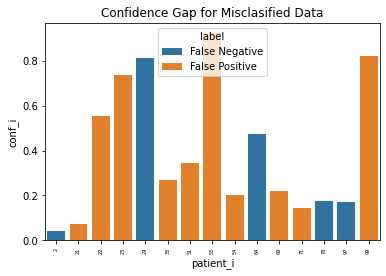

In [21]:
chart = sns.barplot(x="patient_i", y="conf_i", hue="label", data=misclf_df, dodge=False)
for item in chart.get_xticklabels():
    item.set_rotation(90)
    item.set_size(5)
plt.title('Confidence Gap for Misclasified Data')
plt.show()

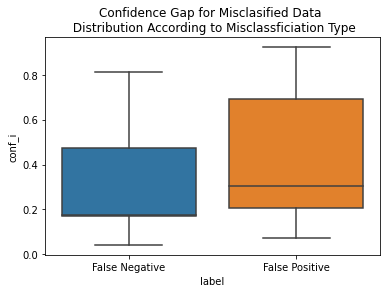

In [22]:
# Plot conf_i
plt.title('Confidence Gap for Misclasified Data \n Distribution According to Misclassficiation Type')
sns.boxplot(y="conf_i", x="label", data=misclf_df)
plt.show()

####Notes:
Here we show the confidence of each misclassification.  The confidence is calculated as the disparity between the positive probability score and the negative probability score assigned by the model.  We notice that there are far more false positives than false negatives.  There is no immediately noticeable difference between the confidence distributions of each misclassification type.


### Plotting Most impactful features (Globally)

In [23]:
gbl_feat_weight = defaultdict(float)
# gbl_feat_count = defaultdict(float)
feats = heart.columns[:-1]

for idx in range(len(y_hold)):
  vals = shap_values[1][idx,:]

  for feat_i, val_i in zip(feats, vals):
    # if val_i*msclf_array[idx] > 0:
    gbl_feat_weight[feat_i] += np.abs(val_i)
    # gbl_feat_count[feat_i] += 1


gbl_weights_df = pd.DataFrame([gbl_feat_weight]).T.reset_index()
gbl_weights_df.columns = ['feature','gbl_weight']
gbl_weights_df = gbl_weights_df.sort_values(['gbl_weight'], ascending=False)
gbl_weights_df

,feature,gbl_weight
2,cp,13.274916
9,oldpeak,12.301580
11,ca,9.250467
7,thalach,5.787727
12,thal,4.697326
3,trestbps,4.334745
4,chol,2.961678
8,exang,2.408131
1,sex,2.356461
0,age,2.351388


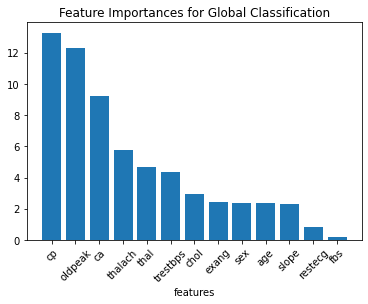

In [24]:
plt.bar(gbl_weights_df['feature'],gbl_weights_df['gbl_weight'])
plt.xticks(rotation = 45)
plt.title('Feature Importances for Global Classification')
plt.xlabel('features')
plt.show()

####Notes:
We use the SHAP weights to develop a notion of feature importances.  For a global sense of feature importances, the magnitude of each feature weight is summed across all data points.


###Plotting Most Contributing Features (Globally)

In [25]:
cont_feat_weight = defaultdict(float)
feats = heart.columns[:-1]
y_hold_1 = np.where(y_hold == 0, -1, y_hold)

for idx in range(len(y_hold)):
  vals = shap_values[1][idx,:]

  for feat_i, val_i in zip(feats, vals):
    if val_i*y_hold_1[idx] > 0:
      cont_feat_weight[feat_i] += np.abs(val_i)
    # gbl_feat_count[feat_i] += 1


cont_weights_df = pd.DataFrame([cont_feat_weight]).T.reset_index()
cont_weights_df.columns = ['feature','gbl_weight']
cont_weights_df = cont_weights_df.sort_values(['gbl_weight'], ascending=False)
cont_weights_df

,feature,gbl_weight
1,cp,9.509298
7,oldpeak,9.306285
12,ca,7.524145
5,thalach,4.311930
9,thal,3.400977
2,trestbps,2.807506
6,exang,1.850901
3,chol,1.788096
0,sex,1.626226
8,slope,1.530187


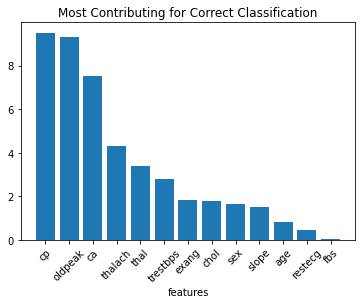

In [26]:
plt.bar(cont_weights_df['feature'],cont_weights_df['gbl_weight'])
plt.xticks(rotation = 45)
plt.title('Most Contributing for Correct Classification')
plt.xlabel('features')
plt.show()

####Notes:
Here we only sum the weights of features that contributed to the correct classification of a data point.  The importances are very similar to the overall weight in the previous chart.

### Plotting Most Impactful Features (False Negative Misclassification)

In [27]:
FN_feat_weight = defaultdict(float)
FN_feat_count = defaultdict(float)
feats = heart.columns[:-1]
msclf_array = (preds_hold - y_hold)


for idx in FN_idx:
  vals = shap_values[1][idx,:]

  for feat_i, val_i in zip(feats, vals):
    if val_i*msclf_array[idx] > 0:
      FN_feat_weight[feat_i] += np.abs(val_i)
      FN_feat_count[feat_i] += 1


FN_weight_df = pd.DataFrame([FN_feat_weight,FN_feat_count]).T.reset_index()
FN_weight_df.columns = ['feature','FN_feat_weight','FN_feat_count']
FN_weight_df = FN_weight_df.sort_values(['FN_feat_weight'], ascending=False)
FN_weight_df

,feature,FN_feat_weight,FN_feat_count
5,oldpeak,0.639627,4.0
0,cp,0.428737,3.0
9,ca,0.402964,1.0
8,trestbps,0.143479,3.0
4,thalach,0.131918,3.0
11,age,0.099543,2.0
6,slope,0.099414,3.0
7,sex,0.085935,4.0
10,thal,0.062154,1.0
1,chol,0.058884,1.0


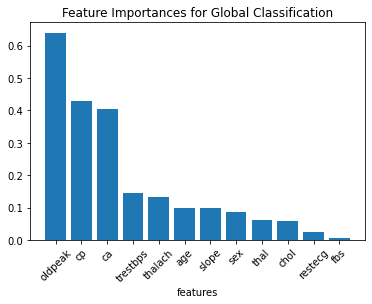

In [28]:
plt.bar(FN_weight_df['feature'],FN_weight_df['FN_feat_weight'])
plt.xticks(rotation = 45)
plt.title('Feature Importances for Global Classification')
plt.xlabel('features')
plt.show()

####Notes:
To determine which features were most influential in false negative misclassification, the magnitude of each feature weight with a negative margin is summed across all data points with a false negative assignment.

### Plotting Most Impactful Features (False Negative Misclassification for Males, the Impacted class)

In [29]:
FN_male_feat_weight = defaultdict(float)
FN_male_feat_count = defaultdict(float)
feats = heart.columns[:-1]
# msclf_array = (preds_hold - y_hold)


for idx in FN_male_idx:
  vals = shap_values[1][idx,:]

  for feat_i, val_i in zip(feats, vals):
    if val_i*msclf_array[idx] > 0:
      FN_male_feat_weight[feat_i] += np.abs(val_i)
      FN_male_feat_count[feat_i] += 1


FN_male_weight_df = pd.DataFrame([FN_male_feat_weight,FN_male_feat_count]).T.reset_index()
FN_male_weight_df.columns = ['feature','FN_male_feat_weight','FN_male_feat_count']
FN_male_weight_df = FN_male_weight_df.sort_values(['FN_male_feat_weight'], ascending=False)
FN_male_weight_df

,feature,FN_male_feat_weight,FN_male_feat_count
9,oldpeak,0.628882,3.0
5,ca,0.402964,1.0
7,cp,0.287999,2.0
1,trestbps,0.143479,3.0
10,age,0.099543,2.0
0,sex,0.085935,4.0
4,slope,0.081453,2.0
6,thal,0.062154,1.0
3,thalach,0.055814,2.0
8,restecg,0.011537,1.0


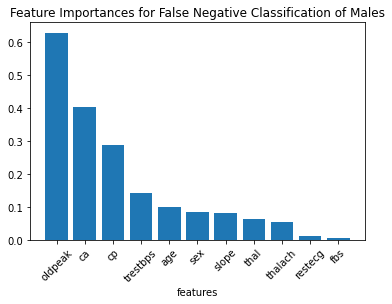

In [30]:
plt.bar(FN_male_weight_df['feature'],FN_male_weight_df['FN_male_feat_weight'])
plt.xticks(rotation = 45)
plt.title('Feature Importances for False Negative Classification of Males')
plt.xlabel('features')
plt.show()

####Notes:
To determine which features were most influential in false negative misclassification for males, the magnitude of each feature weight with a negative margin is summed across all male data points with a false negative assignment.

###General Takeaways
- We notice that the features 'oldpeak,' 'ca,' and 'cp' all contribute for global classification, as well as true negative classification.
- however the "oldpeak" feature plays a more significant role in the misclassification of males than in the global classification.

## Model Repair Using Transparency Metrics
Here we throubleshoot a feature selection method based on our feature importances metrics.  Since 'oldpeak' is more influential when missclassifying males than when

####Format Data
Remove the "oldpeak" feature

In [31]:
oldspeak_idx = np.argwhere(heart.columns =='oldpeak')[0,0]
X_train_fs = np.delete(X_train,oldspeak_idx,1)
X_hold_fs = np.delete(X_hold,oldspeak_idx,1)

In [32]:
#save datasets at BinaryLabelDatasets

#join X and y data together into an array
train_fs_arr = np.hstack((X_train_fs, y_train.reshape(-1,1)))
hold_fs_arr = np.hstack((X_hold_fs, y_hold.reshape(-1,1)))

# #convert back into dataframe
train_fs_df = pd.DataFrame(data=train_fs_arr, columns=heart.columns.drop('oldpeak'))
hold_fs_df = pd.DataFrame(data=hold_fs_arr, columns=heart.columns.drop('oldpeak'))

# #make sure sex remains binary (this was undone with scaling but 0s remained 0)
train_fs_df.loc[train_fs_df.sex != 0, 'sex'] = 1
hold_fs_df.loc[hold_fs_df.sex != 0, 'sex'] = 1

# #convert sex and target back to int
hold_fs_df.sex = hold_fs_df.sex.astype(int)
hold_fs_df.target = hold_fs_df.target.astype(int)

train_fs_df.sex = train_fs_df.sex.astype(int)
train_fs_df.target = train_fs_df.target.astype(int)

In [33]:
#generate binary label datasets for each of the datasets with the truth value for the target
heart_train_fs_dataset_truth = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=train_fs_df,
    label_names=['target'],
    protected_attribute_names=['sex'])

heart_hold_fs_dataset_truth = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=hold_fs_df,
    label_names=['target'],
    protected_attribute_names=['sex'])

heart_train_fs_dataset_preds = heart_train_fs_dataset_truth.copy()
heart_hold_fs_dataset_preds = heart_hold_fs_dataset_truth.copy()

In [34]:
#run this model matching ADS params
model_fs = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1)
model_fs.fit(X_train_fs, y_train)

#confirm same prediction scores as ADS

print('Large Hold-out Set')
print('Test score:',model_fs.score(X_hold_fs, y_hold))

#save preditions on test data
preds_fs_hold = model_fs.predict(X_hold_fs)

Large Hold-out Set
Test score: 0.87


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


####Print Metrics

In [35]:
# Compute the accuracy of the classifier and the number of misclassified documents
print("misclassification count: {}".format(np.sum(preds_fs_hold != y_hold)))
print('confusion matrix:')
confusion_matrix(y_hold, preds_fs_hold)

misclassification count: 13
confusion matrix:


array([[40,  8],
       [ 5, 47]])

In [36]:
#save predictions into the dataset
heart_hold_fs_dataset_preds.labels = preds_fs_hold.reshape(-1,1)

privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

#get classification metrics on test data
metrics = ClassificationMetric(heart_hold_fs_dataset_truth, heart_hold_fs_dataset_preds,
                      unprivileged_groups=unprivileged_groups,
                      privileged_groups=privileged_groups)

In [37]:
#print comparison metrics
print("Overall Test Accuracy:", metrics.accuracy())
print("Male Test Accuracy:", metrics.accuracy(privileged=True))
print("Female Test Accuracy:", metrics.accuracy(privileged=False))
print('')
print("Test Disparate Impact:", metrics.disparate_impact())
print('')
print("Test FPR:", metrics.false_positive_rate())
print("Test FPR Difference:", metrics.false_positive_rate_difference())
print("")
print("Test FNR:", metrics.false_negative_rate())
print("Test FNR Difference:", metrics.false_negative_rate_difference())
print('')
print("Confusion Matrix:")
print(confusion_matrix(y_hold, preds_fs_hold))

Overall Test Accuracy: 0.87
Male Test Accuracy: 0.8493150684931506
Female Test Accuracy: 0.9259259259259259

Test Disparate Impact: 1.6699346405228759

Test FPR: 0.16666666666666666
Test FPR Difference: -0.18181818181818182

Test FNR: 0.09615384615384616
Test FNR Difference: -0.01649175412293853

Confusion Matrix:
[[40  8]
 [ 5 47]]


####Print Plots

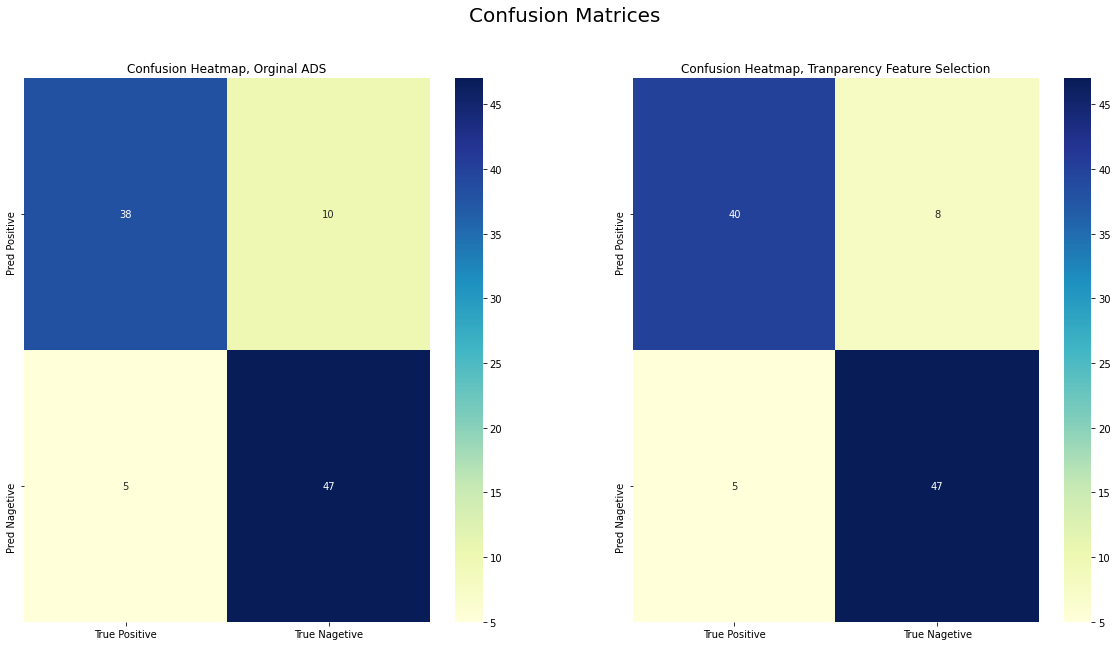

In [38]:
fig, ax = plt.subplots(1,2, figsize = (20,10))

sns.heatmap(confusion_matrix(y_hold, preds_hold),annot=True,cmap="YlGnBu", xticklabels = ['True Positive','True Nagetive'],
            yticklabels = ['Pred Positive','Pred Nagetive'], ax=ax[0])
ax[0].set_title('Confusion Heatmap, Orginal ADS')

sns.heatmap(confusion_matrix(y_hold, preds_fs_hold),annot=True,cmap="YlGnBu", xticklabels = ['True Positive','True Nagetive'],
            yticklabels = ['Pred Positive','Pred Nagetive'], ax=ax[1])
ax[1].set_title('Confusion Heatmap, Tranparency Feature Selection')

plt.suptitle('Confusion Matrices',size=20)
plt.show()


####Notes
- The method rescues some misclassified positive instances which improves the difference in accuracy, FNR, FPR, and disparate impact of the model
- This is just a baseline example for what transparency methods can accomplish in model building